In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.random as npr
from numba import jit,  njit, float64

from math import pi, cos, sin
tau = 2*pi

In [2]:
bounds=[[0.,tau/8],[3*tau/8,tau/2]]

In [3]:
@njit
def random_disjoint_intervals(bounds):
    lens = collapse_intervals(bounds)
    total_len=lens[-1]
    
    R=npr.rand()*total_len
    
    idx=0
    for i in range(len(bounds)):
        if R <= lens[i]:
            idx = i
            break
    lb = bounds[idx][0]
    ub = bounds[idx][1]
    R_star = (ub-lb)*npr.rand()+lb
    return R_star

@njit
def collapse_intervals(bounds):
    lens=[]
    for i in range(len(bounds)):
        lb=bounds[i][0]
        ub=bounds[i][1]
        lens.append(ub-lb)
    lens=np.array(lens)
    return lens.cumsum()

def check_bounds(v,bounds):
    for b in bounds:
        if v>=b[0] and v<=b[1]:
            return v
    return min([(abs(x-v),x) for x in bounds.flatten()])[1]

for i in range(10):
    print(check_bounds(i,np.array([[1,1.5],[7.5,9]])))
        

1.0
1
1.5
1.5
1.5
7.5
7.5
7.5
8
9


In [20]:
%timeit random_disjoint_intervals(np.array([[0.,3.],[3.5,10.]]))
%timeit check_bounds(10,np.array([[1,1.5],[7.5,9]]))

1.75 µs ± 8.12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5.68 µs ± 28.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


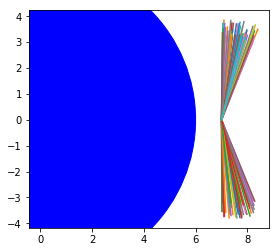

In [5]:
N=10000
bounds={'pos':np.array([[0,0*tau]]),'ang':np.array([[0,1*tau/16],[tau/2-tau/16,tau/2]]),'burn':np.array([[3.2,3.9]])}
pts=[]
for i in range(N):
    newpt=[]
    for b in bounds.values():
        newpt.append(random_disjoint_intervals(b))
    pts.append(newpt)
    
# for i,x in enumerate(np.array(pts).T):
#     plt.hist(x,bins=100)
#     plt.show()
    
ax=plt.gca()
earth=plt.Circle((0,0),6,color='blue')
ax.set_aspect('equal')
for psi in pts[::100]:
    pos,ang,burn=psi
    
    vhat_x,vhat_y=sin(pos),-cos(pos)
    x0,y0 = 7*cos(pos),7*sin(pos)
    burnvx=cos(ang)*vhat_x - sin(ang) * vhat_y
    burnvy=sin(ang)*vhat_x + cos(ang) * vhat_y
    
    
    ax.plot([x0,burn*burnvx+x0],[y0,burn*burnvy+y0])
ax.scatter(0,0) # make sur earth is on screen
ax.add_artist(earth)
plt.show()

In [6]:
bounds.values()

dict_values([array([[0., 0.]]), array([[0.        , 0.39269908],
       [2.74889357, 3.14159265]]), array([[3.2, 3.9]])])

In [7]:
for b in enumerate(bounds.values()):
    print(b)

(0, array([[0., 0.]]))
(1, array([[0.        , 0.39269908],
       [2.74889357, 3.14159265]]))
(2, array([[3.2, 3.9]]))


# Matrix Transformations
## ES algo GPU version

In [400]:

from scipy.stats import rankdata

In [401]:
indi, jit = 5, 3
sigma,alpha=0.3,0.03
indivs=[[1,1,1],[10,10,10],[100,100,100],[1000,1000,1000],[10000,10000,10000]]
jitter=np.random.rand(indi,jit,3)
jitter=np.array([sigma*jitt for jitt in jitter])
jitter=jitter.reshape(jit,indi,3)
jitter[0]*=0
points=indivs+jitter
points=points.reshape(jit*indi,3)
points=np.array([p * 2 for p in points]) # TODO replace with ensure_bounds eval
points.reshape(jit,indi,3)
successes=np.zeros(indi*jit,dtype=bool)
scores=np.zeros(indi*jit)

## Simulations are run here

In [402]:
successes[:int(indi*jit/2)]=True
print(successes)
scores = np.arange(indi*jit,dtype=float)
for i,_ in enumerate(scores):
    scores[i] += points[i][2]
    if not successes[i]:
        scores[i] += 10
        scores[i] *= 10

successes = successes.reshape(jit,indi)
scores = scores.reshape(jit,indi)
scores=scores.T
print (scores)
scores = np.array([rankdata(sig_eps,method='ordinal') for sig_eps in scores])
scores = -scores



[ True  True  True  True  True  True  True False False False False False
 False False False]
[[2.00000000e+00 7.12954072e+00 2.24962715e+02]
 [2.10000000e+01 2.61041713e+01 4.14268164e+02]
 [2.02000000e+02 2.17141015e+03 2.22462077e+03]
 [2.00300000e+03 2.01858766e+04 2.02351582e+04]
 [2.00040000e+04 2.00194609e+05 2.00240184e+05]]


In [403]:
steps=np.zeros([indi,3])
jitterT=jitter.transpose(1,0,2)
print(jitterT,jitterT.shape)
steps=np.array([np.dot(scores[idx],jitterT[idx]) * alpha for idx in range(len(steps))])

[[[0.         0.         0.        ]
  [0.22944796 0.200461   0.06477036]
  [0.05684932 0.00658754 0.24813575]]

 [[0.         0.         0.        ]
  [0.01671545 0.0013616  0.05208565]
  [0.05739913 0.02149737 0.21340819]]

 [[0.         0.         0.        ]
  [0.23105948 0.17734574 0.07050755]
  [0.23695079 0.05558903 0.23103854]]

 [[0.         0.         0.        ]
  [0.08263094 0.06715965 0.29383074]
  [0.01062752 0.00764476 0.25791248]]

 [[0.         0.         0.        ]
  [0.2287158  0.10052874 0.23045142]
  [0.16464892 0.15958612 0.00920364]]] (5, 3, 3)


In [404]:
myvars=['indi','jit','indivs','jitter','points','successes','scores','steps','scores[0]','jitterT']
for name in myvars:
    shape=''
    if eval(name) is np.array:
        shape=eval(name).shape
    print(f"{name}\n  {eval(name)}, {shape}\n")

indi
  5, 

jit
  3, 

indivs
  [[1, 1, 1], [10, 10, 10], [100, 100, 100], [1000, 1000, 1000], [10000, 10000, 10000]], 

jitter
  [[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.22944796 0.200461   0.06477036]
  [0.01671545 0.0013616  0.05208565]
  [0.23105948 0.17734574 0.07050755]
  [0.08263094 0.06715965 0.29383074]
  [0.2287158  0.10052874 0.23045142]]

 [[0.05684932 0.00658754 0.24813575]
  [0.05739913 0.02149737 0.21340819]
  [0.23695079 0.05558903 0.23103854]
  [0.01062752 0.00764476 0.25791248]
  [0.16464892 0.15958612 0.00920364]]], 

points
  [[2.00000000e+00 2.00000000e+00 2.00000000e+00]
 [2.00000000e+01 2.00000000e+01 2.00000000e+01]
 [2.00000000e+02 2.00000000e+02 2.00000000e+02]
 [2.00000000e+03 2.00000000e+03 2.00000000e+03]
 [2.00000000e+04 2.00000000e+04 2.00000000e+04]
 [2.45889592e+00 2.40092200e+00 2.12954072e+00]
 [2.00334

In [392]:
print(jitter.transpose(1,0,2))

[[[0.         0.         0.        ]
  [0.1280431  0.12180758 0.01018593]
  [0.18669717 0.18058165 0.18075414]]

 [[0.         0.         0.        ]
  [0.03645558 0.26442544 0.18639281]
  [0.01882341 0.11633155 0.13459434]]

 [[0.         0.         0.        ]
  [0.04220892 0.26965698 0.02896902]
  [0.06873238 0.07552495 0.00311146]]

 [[0.         0.         0.        ]
  [0.19940603 0.20497647 0.29552359]
  [0.03876768 0.1418851  0.25727366]]

 [[0.         0.         0.        ]
  [0.02567414 0.03599377 0.1412781 ]
  [0.14153639 0.17431669 0.12801141]]]
